In [2]:
"""
sudo apt install python3-pip python3-dev
pip3 install ipympl
pip3 install jupyterlab
pip3 install Pillow
jupyter-labextension install @jupyter-widgets/jupyterlab-manager
%matplotlib widget
"""
#interactive
#%matplotlib widget
#for pdf export
%matplotlib inline

import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.2.0


uint8
(2835, 2008)
<class 'numpy.ndarray'>


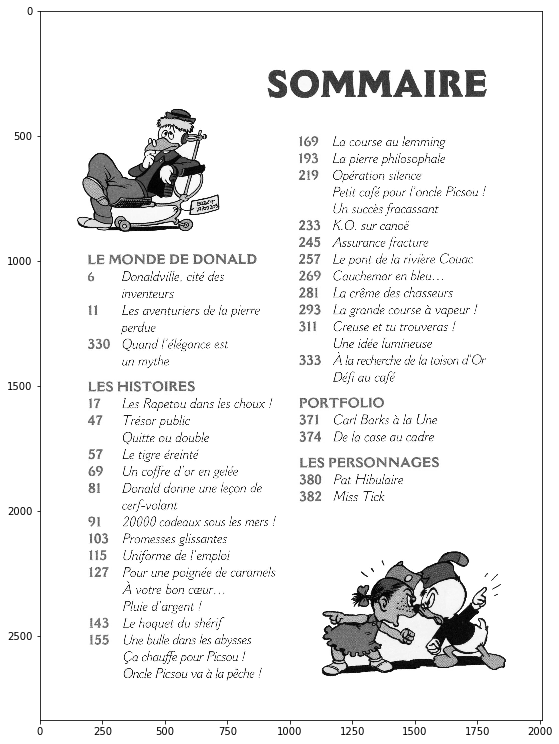

In [3]:
from PIL import Image
import PIL.ImageOps 
image = Image.open('ex/index-5_1.jpg').convert('L')
image_inv = PIL.ImageOps.invert(image)

#from https://matplotlib.org/3.2.1/tutorials/introductory/images.html
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import numpy as np
#img = mpimg.imread('ex/index-71_1.jpg')
img = np.array(image)
img_inv = np.array(image_inv)
print(img.dtype)
print(img.shape)
print(type(img))
plt.close()
fix, axe0 = plt.subplots(figsize=(9,16))
imgplot = axe0.imshow(img, cmap="gray")

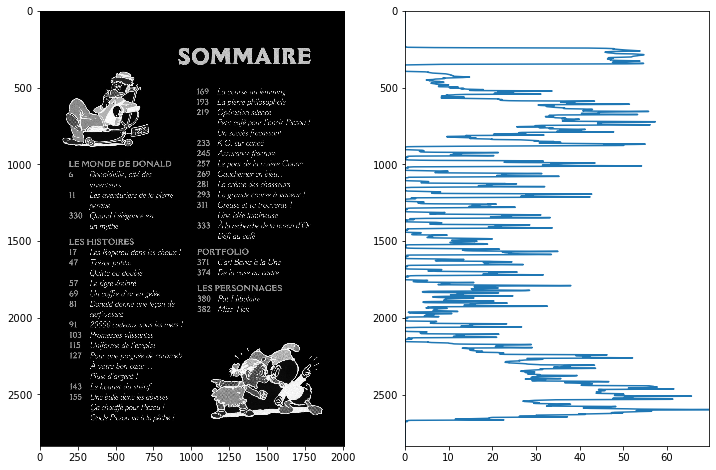

In [4]:
lines_i = np.arange(img.shape[0])
v_avg = np.average(img_inv, axis=1)

plt.close()
fix, (ax0, ax1) = plt.subplots(1,2,figsize=(12,8))
ax0.imshow(img_inv, aspect="auto", cmap="gray")
#ax1.barh(lines_i, v_avg, orientation='horizontal')
#ax1.invert_yaxis()

ax1.plot(v_avg, lines_i)
ax1.invert_yaxis()
ax1.margins(0)

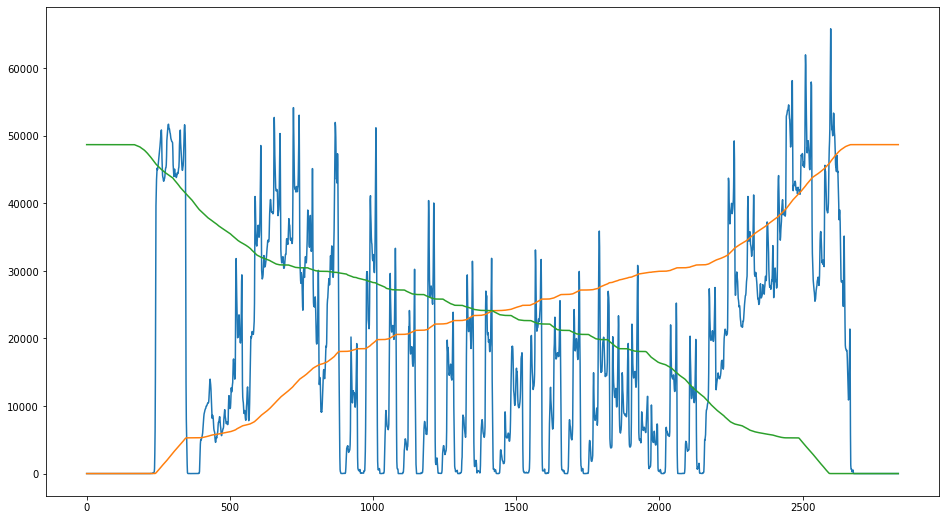

In [5]:
v_sum1=np.cumsum(v_avg)
v_sum2=v_sum1[-1]-np.cumsum(np.flip(v_avg))
plt.close()
fix, axe0 = plt.subplots(figsize=(16,9))
axe0.plot(lines_i, v_avg*img.shape[0]/3, lines_i, v_sum1, lines_i, v_sum2)

https://scipy-lectures.org/advanced/mathematical_optimization/
On va séparer les 3 zones :
 - haut
 - milieu
 - bas
=> plus simple si aucun lien entre les zones !
=> on peut faire de la corrélation pour trouver les meilleures zones et ajouter des contraintes sur la position ou les données perdues pour optimiser ?
mais est-ce que la corrélation est la meilleure chose ? Il ne vaudrait pas mieux faire de façon binaire ? Y'a les zones où c'est tout blanc et les autres.

(2835,) (2835,)


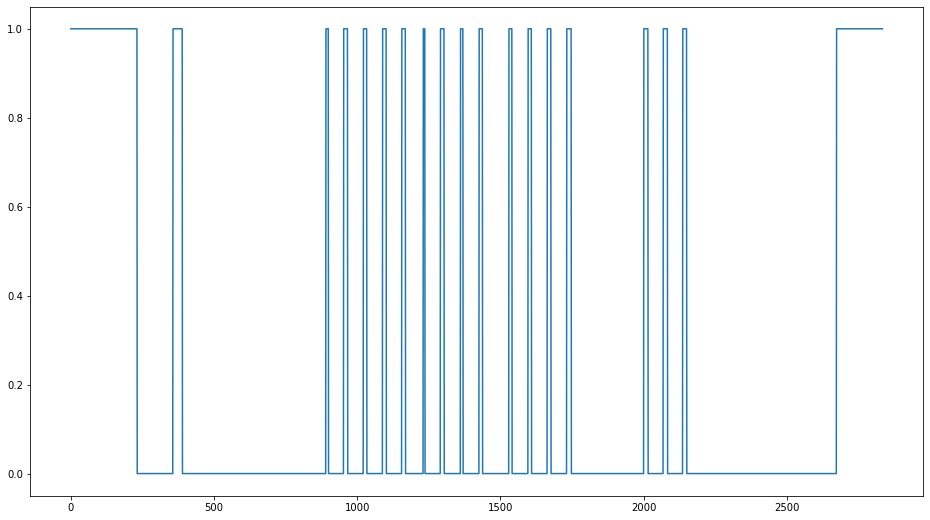

In [8]:
#we look for blank_sz consecutive blank lines
blank_sz = 15
blank = np.ones(blank_sz)/blank_sz
half_blank = np.ones(blank_sz//2)

corr = np.concatenate( (half_blank,
                      (np.correlate(blank,(np.flip(v_avg)<2))>0.9),
                      half_blank) )
#corr = v_avg<10
plt.close()
fix, axe0 = plt.subplots(figsize=(16,9))
axe0.plot(corr)
print(np.shape(v_avg),np.shape(corr))

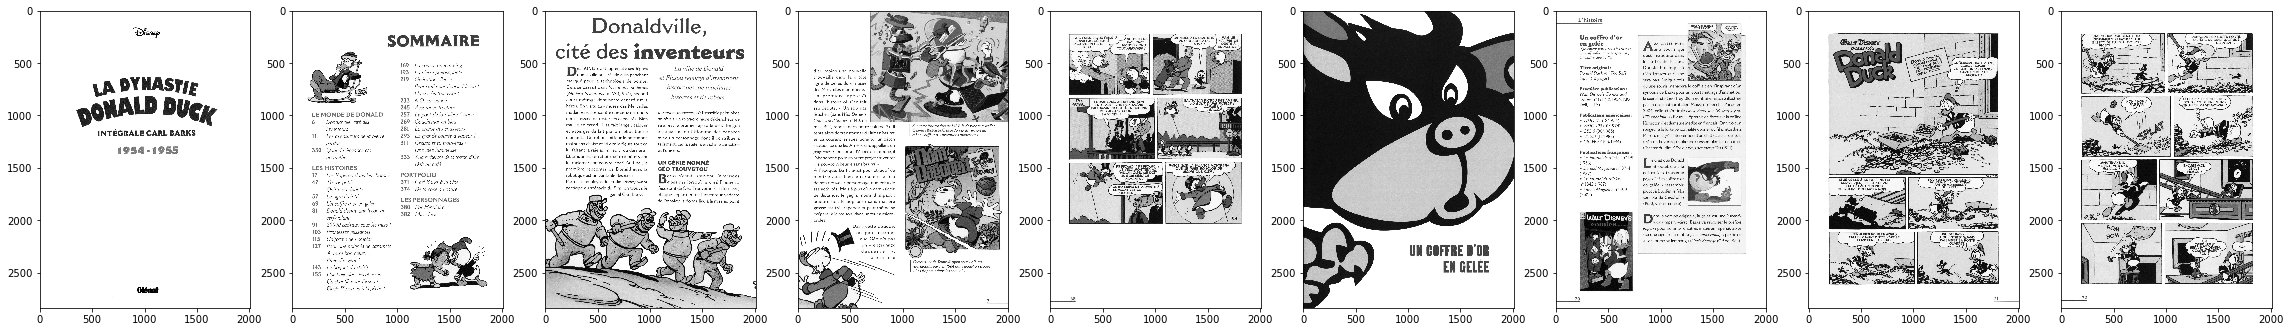

In [13]:
all_img_path=['ex/index-4_1.jpg','ex/index-5_1.jpg','ex/index-6_1.jpg','ex/index-7_1.jpg','ex/index-67_1.jpg','ex/index-68_1.jpg','ex/index-69_1.jpg','ex/index-70_1.jpg','ex/index-71_1.jpg']

plt.close()
fix, ax = plt.subplots(1, len(all_img_path), figsize=(40,8))
for i in range(len(all_img_path)):
    imgplot = ax[i].imshow(all_img[i], cmap="gray")

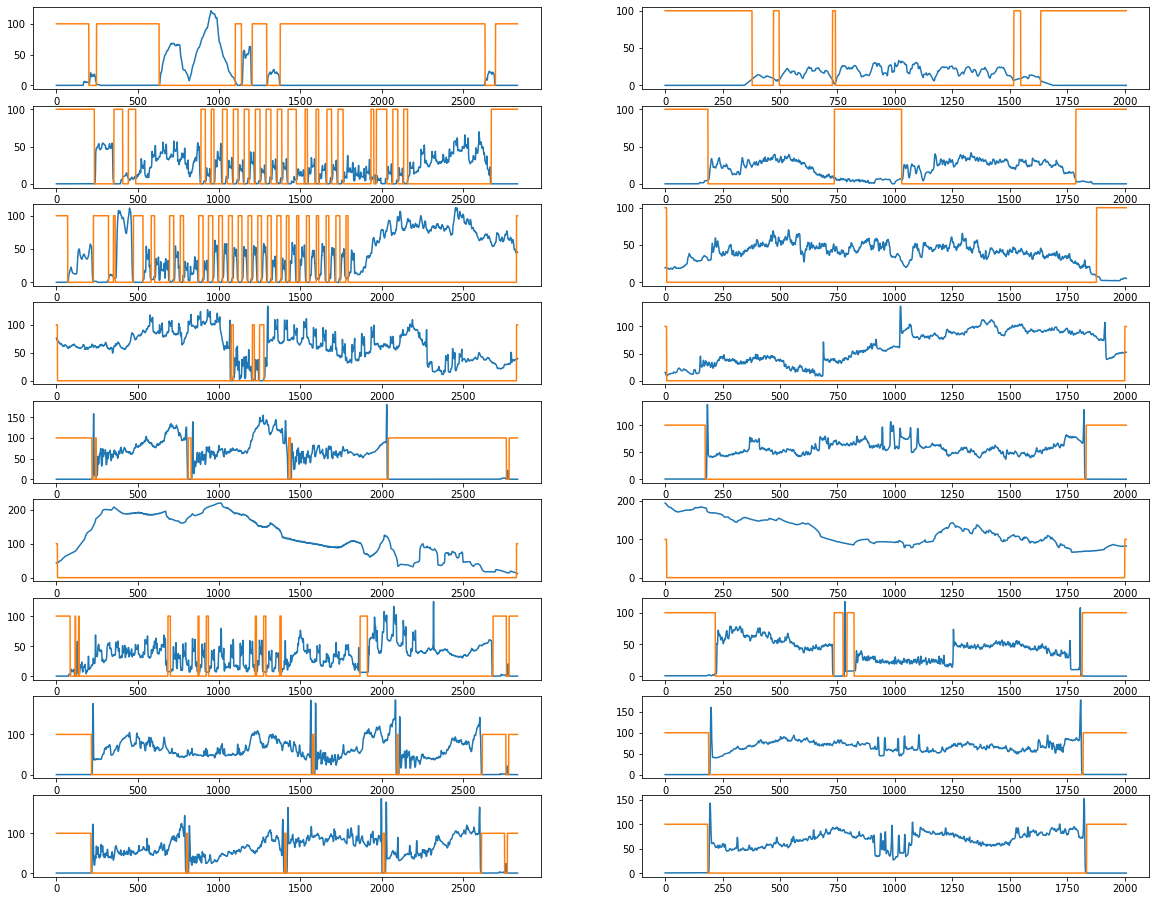

In [14]:
all_jpg = []
all_img = []
all_v_avg = []
all_v_sum1 = []
all_v_sum2 = []
all_corr_v = []
all_h_avg = []
all_h_sum1 = []
all_h_sum2 = []
all_corr_h = []

def read_img(path):
    image = Image.open(path).convert('L')
    all_jpg.append(image)
    all_img.append(np.array(image))
    image_inv = PIL.ImageOps.invert(image)
    img_inv = np.array(image_inv)
    all_v_avg.append(np.average(img_inv, axis=1))
    all_v_sum1.append(np.cumsum(all_v_avg[-1]))
    all_v_sum2.append(np.flip(np.cumsum(np.flip(all_v_avg[-1]))))
    all_h_avg.append(np.average(img_inv, axis=0))
    all_h_sum1.append(np.cumsum(all_h_avg[-1]))
    all_h_sum2.append(np.flip(np.cumsum(np.flip(all_h_avg[-1]))))

def corr(i):
    all_corr_v.append(np.concatenate( (half_blank,
                      (np.correlate(blank,(np.flip(all_v_avg[i])<10))>0.9),
                      half_blank) ))
    all_corr_h.append(np.concatenate( (half_blank,
                      (np.correlate(blank,(np.flip(all_h_avg[i])<10))>0.9),
                      half_blank) ))
    
def plot_v(ax, i):
    lines_i = np.arange(len(all_v_avg[-1]))
    #ax[i].plot(lines_i, all_v_avg[i]*len(all_v_avg[i])/3, lines_i, all_v_sum1[i], lines_i, all_v_sum2[i])
    ax[i].plot(lines_i, all_v_avg[i])
    #ax[i].plot(lines_i, all_v_avg[i]<5)
    ax[i].plot(lines_i, all_corr_v[i]*100)

def plot_h(ax, i):
    lines_i = np.arange(len(all_h_avg[-1]))
    #ax[i].plot(all_h_avg[i]*len(all_h_avg[i])/3)
    #ax[i].plot(all_h_sum1[i], all_h_sum2[i])
    ax[i].plot(all_h_avg[i])
    #ax[i].plot(all_h_avg[i]<5)
    ax[i].plot(all_corr_h[i]*100)

    
plt.close()
fix, ax = plt.subplots(len(all_img_path), 2, figsize=(20,16))
for i in range(len(all_img_path)):
    read_img(all_img_path[i])
    corr(i)
    plot_v(ax[:,0], i)
    plot_h(ax[:,1], i)


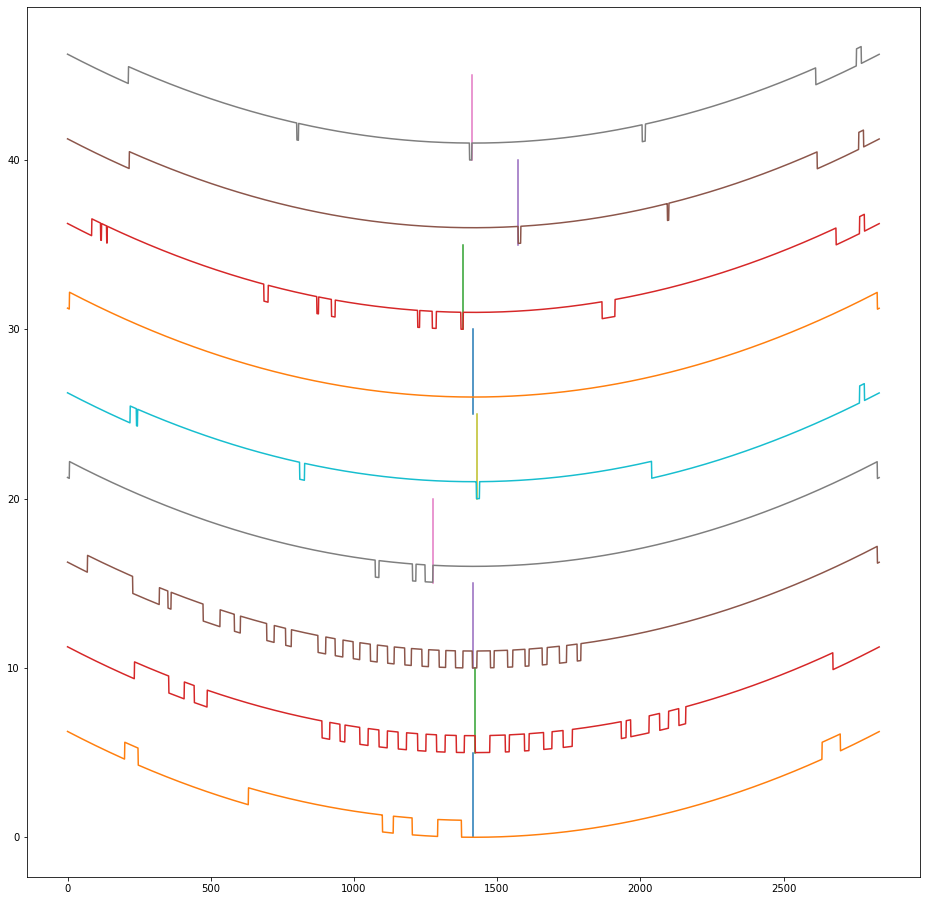

In [15]:
#find middle
plt.close()
fix, ax = plt.subplots(figsize=(16,16))
all_best_m = []
def getBestMid(i):
    lines_i = np.arange(len(all_v_avg[-1]))
    corr = all_corr_v[i]
    sz = len(corr)
    all_scores = []
    min_score = 10000
    min_score_index = 0
    for j in range(sz):
        score = np.abs(np.square(5*(j-sz/2)/sz)) + (1-corr[j])
        all_scores.append(score+i*5)
        if score < min_score:
            min_score = score
            min_score_index = j
    ax.plot((min_score_index,min_score_index), (0+i*5,5+i*5))
    ax.plot(lines_i, all_scores)
    return min_score_index

for i in range(len(all_img_path)):
    all_best_m.append(getBestMid(i))

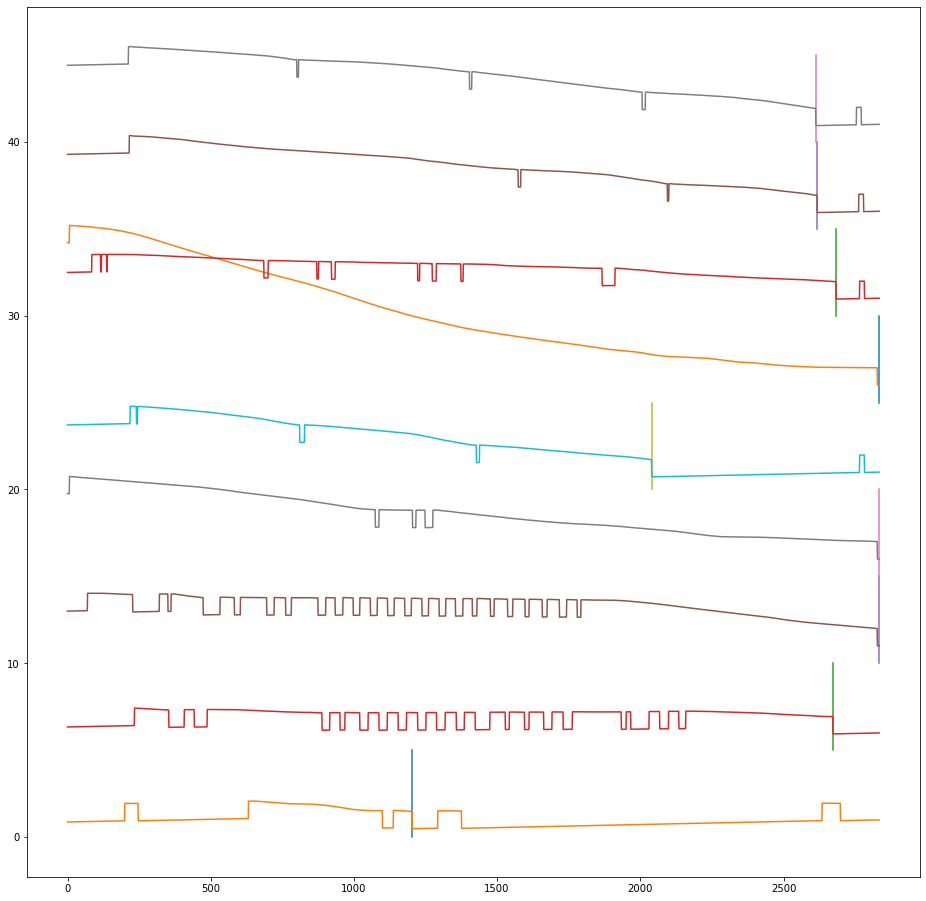

In [16]:
#find bottom
plt.close()
fix, ax = plt.subplots(figsize=(16,16))
all_best_b = []
def getBestBottom(i):
    lines_i = np.arange(len(all_v_avg[-1]))
    corr = all_corr_v[i]
    v_sum2 = all_v_sum2[i]
    sz = len(corr)
    all_scores = []
    min_score = 10000
    min_score_index = 0
    for j in range(sz):
        score = j/sz + (1-corr[j]) + 20*v_sum2[j]/sz/256
        all_scores.append(score+i*5)
        if score < min_score:
            min_score = score
            min_score_index = j
    ax.plot((min_score_index,min_score_index), (0+i*5,5+i*5))
    ax.plot(lines_i, all_scores)
    #ax.plot(20*v_sum2/sz/256+i*5)
    return min_score_index

for i in range(len(all_img_path)):
    all_best_b.append(getBestBottom(i))

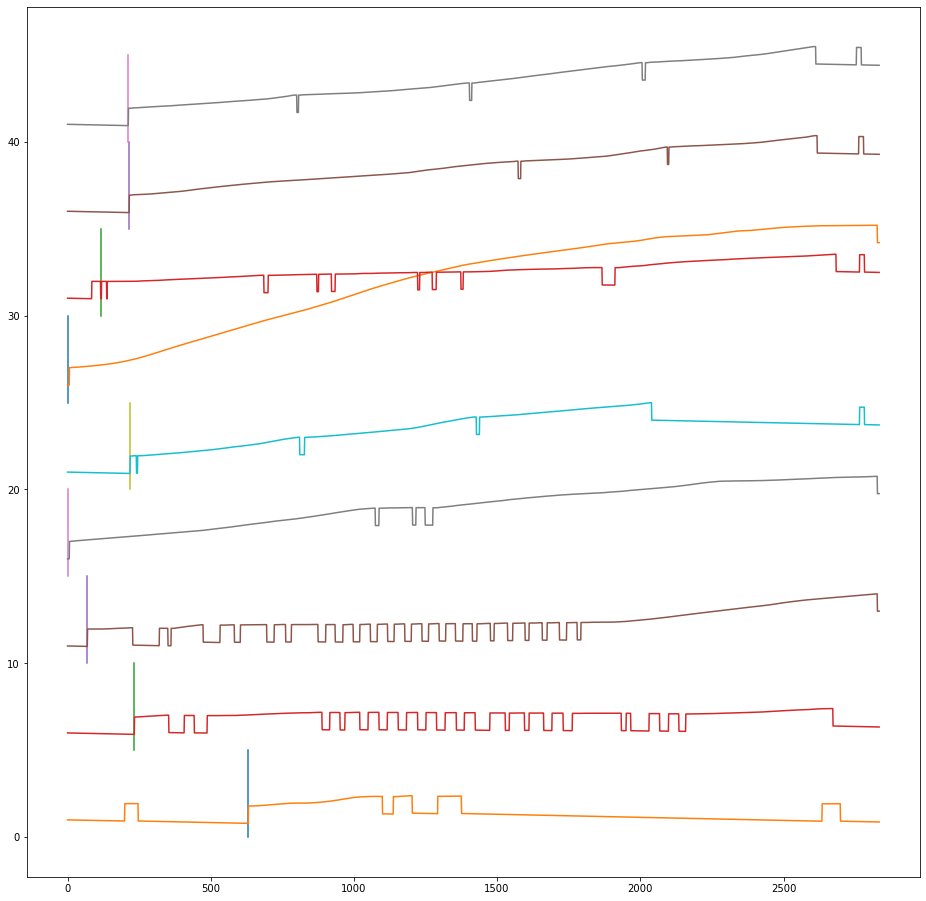

In [17]:
#find top
plt.close()
fix, ax = plt.subplots(figsize=(16,16))
all_best_t = []
def getBestTop(i):
    lines_i = np.arange(len(all_v_avg[-1]))
    corr = all_corr_v[i]
    v_sum1 = all_v_sum1[i]
    sz = len(corr)
    all_scores = []
    min_score = 10000
    min_score_index = 0
    for j in range(sz):
        score = (sz-j)/sz + (1-corr[j]) + 20*v_sum1[j]/sz/256
        all_scores.append(score+i*5)
        if score < min_score:
            min_score = score
            min_score_index = j
    ax.plot((min_score_index,min_score_index), (0+i*5,5+i*5))
    ax.plot(lines_i, all_scores)
    #ax.plot(20*v_sum1/sz/256+i*5)
    return min_score_index

for i in range(len(all_img_path)):
    all_best_t.append(getBestTop(i))

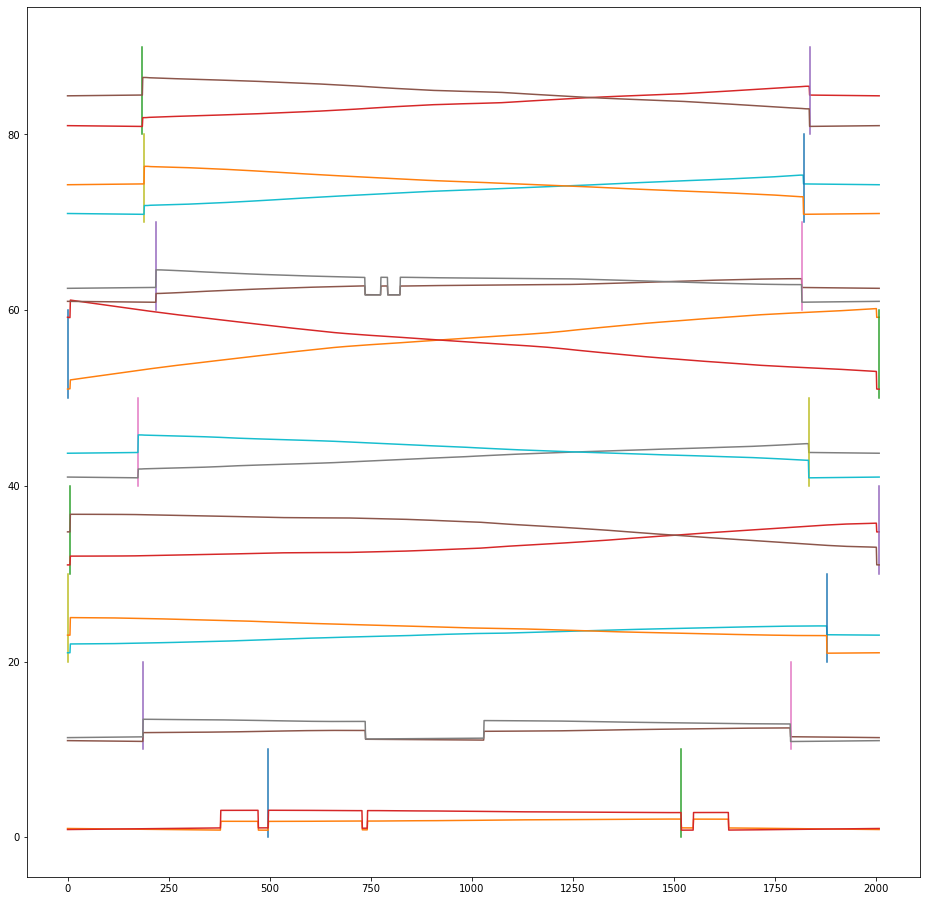

In [18]:
#find sides
plt.close()
fix, ax = plt.subplots(figsize=(16,16))
all_best_l = []
all_best_r = []
def getBestSides(i):
    corr = all_corr_h[i]
    h_sum1 = all_h_sum1[i]
    h_sum2 = all_h_sum2[i]
    sz = len(corr)
    all_scores_l = []
    min_score_l = 10000
    min_score_l_index = 0
    all_scores_r = []
    min_score_r = 10000
    min_score_r_index = 0
    for j in range(sz):
        score_l = (sz-j)/sz + (1-corr[j]) + 20*h_sum1[j]/sz/256
        all_scores_l.append(score_l+i*10)
        if score_l < min_score_l:
            min_score_l = score_l
            min_score_l_index = j
    for j in range(sz):
        score_r = j/sz + (1-corr[j]) + (1-corr[j]) + 20*h_sum2[j]/sz/256
        all_scores_r.append(score_r+i*10)
        if score_r < min_score_r:
            min_score_r = score_r
            min_score_r_index = j
    ax.plot((min_score_l_index,min_score_l_index), (0+i*10,10+i*10))
    ax.plot(all_scores_l)
    ax.plot((min_score_r_index,min_score_r_index), (0+i*10,10+i*10))
    ax.plot(all_scores_r)
    return min_score_l_index,min_score_r_index

for i in range(len(all_img_path)):
    l,r = getBestSides(i)
    all_best_l.append(l)
    all_best_r.append(r)

In [19]:
epaper_prop = 157/118 #4/3
overlap = 0.05 #relative to page height
height = len(all_v_avg[0])

for i in range(len(all_img_path)):
    print(all_best_t[i],all_best_l[i],all_best_r[i],all_best_m[i],all_best_b[i])

#all margins for upper and lower parts
all_marginU_w = []
all_marginU_h = []
all_marginL_w = []
all_marginL_h = []

#find final half pages:
#if selection_prop < epaper_prop, must increase l/r margins
#else, must increase middle margin
for i in range(len(all_img_path)):
    for is_up in (True, False):
        margin_w = 0
        margin_h = 0
        selection_w = all_best_r[i]-all_best_l[i]+2*margin_w
        if is_up:
            selection_h = all_best_m[i]+overlap*height-all_best_t[i]+margin_h
        else:
            selection_h = all_best_b[i]-all_best_m[i]+overlap*height+margin_h
        selection_prop = selection_w / selection_h
        print("Before adaptation:",selection_prop, epaper_prop)
        if selection_prop < epaper_prop:
            margin_w = (epaper_prop-selection_prop)*selection_h/2
        if selection_prop > epaper_prop:
            margin_h = selection_h*(selection_prop/epaper_prop-1)

        selection_w_test = all_best_r[i]-all_best_l[i]+2*margin_w
        if is_up:
            selection_h_test = all_best_m[i]+overlap*height-all_best_t[i]+margin_h
        else:
            selection_h_test = all_best_b[i]-all_best_m[i]+overlap*height+margin_h
        selection_prop_test = selection_w_test / selection_h_test
        print("After adaptation:",selection_prop_test, epaper_prop, margin_w, margin_h)
        if is_up:
            all_marginU_w.append(margin_w)
            all_marginU_h.append(margin_h)
        else:
            all_marginL_w.append(margin_w)
            all_marginL_h.append(margin_h)

print(all_marginU_w)
print(all_marginU_h)
print(all_marginL_w)
print(all_marginL_h)


631 496 1518 1417 1204
233 186 1788 1424 2673
69 0 1878 1417 2834
0 6 2007 1275 2834
218 174 1833 1428 2040
0 0 2007 1417 2832
118 218 1816 1381 2684
215 189 1820 1574 2618
212 185 1835 1411 2613
Before adaptation: 1.1015898679601186 1.3305084745762712
After adaptation: 1.3305084745762712 1.3305084745762712 106.18961864406779 0
Before adaptation: -14.343859649122807 1.3305084745762712
After adaptation: 1.3305084745762719 1.3305084745762712 -558.3993644067797 0
Before adaptation: 1.2020258863252673 1.3305084745762712
After adaptation: 1.3305084745762712 1.3305084745762712 85.61758474576271 0
Before adaptation: 1.1518964587452813 1.3305084745762712
After adaptation: 1.3305084745762712 1.3305084745762712 124.20233050847456 0
Before adaptation: 1.2606141970129217 1.3305084745762712
After adaptation: 1.3305084745762712 1.3305084745762712 52.062499999999986 0
Before adaptation: 1.204811547714515 1.3305084745762712
After adaptation: 1.330508474576271 1.3305084745762712 97.96504237288129 0
Bef

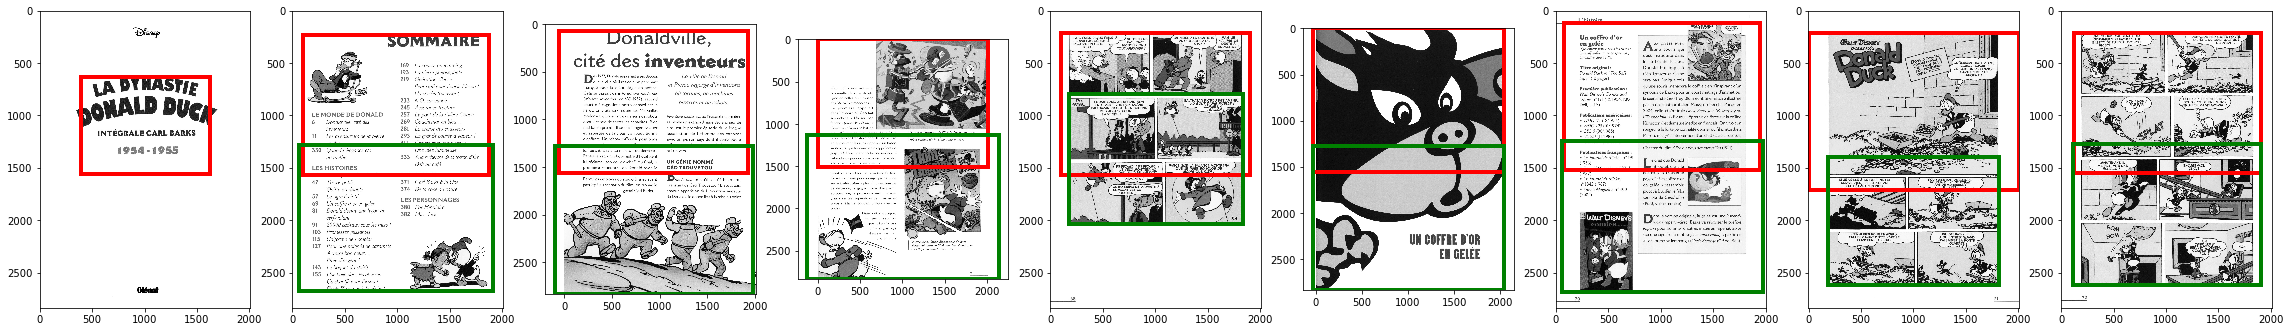

In [20]:
plt.close()
fix, ax = plt.subplots(1, len(all_img_path), figsize=(40,8))

for i in range(len(all_img_path)):
    imgplot = ax[i].imshow(all_img[i], cmap="gray")
    cut_l = all_best_l[i]-all_marginU_w[i]
    cut_r = all_best_r[i]+all_marginU_w[i]
    cut_t = all_best_t[i]
    cut_m = all_best_m[i]+all_marginU_h[i]+overlap*height
    if cut_m>cut_t:
        crop = all_jpg[i].crop((cut_l, cut_t, cut_r, cut_m))
        crop.save(all_img_path[i]+"_0.jpg")
        ax[i].plot((cut_l, cut_r), (cut_t, cut_t), linewidth=4, color='r')
        ax[i].plot((cut_l, cut_l), (cut_t, cut_m), linewidth=4, color='r')
        ax[i].plot((cut_r, cut_r), (cut_t, cut_m), linewidth=4, color='r')
        ax[i].plot((cut_l, cut_r), (cut_m, cut_m), linewidth=4, color='r')
    cut_l = all_best_l[i]-all_marginL_w[i]
    cut_r = all_best_r[i]+all_marginL_w[i]
    cut_m = all_best_m[i]-all_marginL_h[i]-overlap*height
    cut_b = all_best_b[i]
    if cut_b>cut_m:
        crop = all_jpg[i].crop((cut_l, cut_m, cut_r, cut_b))
        crop.save(all_img_path[i]+"_1.jpg")
        ax[i].plot((cut_l, cut_r), (cut_b, cut_b), linewidth=4, color='g')
        ax[i].plot((cut_l, cut_l), (cut_b, cut_m), linewidth=4, color='g')
        ax[i].plot((cut_r, cut_r), (cut_b, cut_m), linewidth=4, color='g')
        ax[i].plot((cut_l, cut_r), (cut_m, cut_m), linewidth=4, color='g')
        
        